# simran4@wisc.edu, rgundavarapu@wisc.edu

# PART 1: Data Setup

In [1]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/03 02:07:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!curl https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip > wi-2021.zip
!curl https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip > arid-2017.zip
!curl https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip > code_sheets.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.4M  100 20.4M    0     0  26.5M      0 --:--:-- --:--:-- --:--:-- 26.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  141k  100  141k    0     0   384k      0 --:--:-- --:--:-- --:--:--  384k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  779k  100  779k    0     0  1748k      0 --:--:-- --:--:-- --:--:-- 1751k


In [3]:
import zipfile as zf
import glob
 
zips = [zf.ZipFile('wi-2021.zip'),zf.ZipFile('arid-2017.zip'),zf.ZipFile('code_sheets.zip')]

for zipfiles in zips:
    zipfiles.extractall()
    
csv_dict = {}
path = "./*.csv"
for file_name in glob.glob(path):
    file_name = str(file_name[2:])
    !hdfs dfs -cp {file_name} hdfs://main:9000/{file_name}

In [4]:
!hdfs dfs -du -h hdfs://main:9000/

328      984      hdfs://main:9000/action_taken.csv
317      951      hdfs://main:9000/agency.csv
521.0 K  1.5 M    hdfs://main:9000/arid2017_to_lei_xref_csv.csv
311.6 K  934.8 K  hdfs://main:9000/counties.csv
237      711      hdfs://main:9000/denial_reason.csv
109      327      hdfs://main:9000/edit_status.csv
180      540      hdfs://main:9000/ethnicity.csv
166.8 M  500.5 M  hdfs://main:9000/hdma-wi-2021.csv
41       123      hdfs://main:9000/hoepa.csv
114      342      hdfs://main:9000/lien_status.csv
65       195      hdfs://main:9000/loan_purpose.csv
79       237      hdfs://main:9000/loan_type.csv
129.6 K  388.7 K  hdfs://main:9000/msamd.csv
122      366      hdfs://main:9000/owner_occupancy.csv
92       276      hdfs://main:9000/preapproval.csv
127      381      hdfs://main:9000/property_type.csv
387      1.1 K    hdfs://main:9000/purchaser_type.csv
252      756      hdfs://main:9000/race.csv
144      432      hdfs://main:9000/sex.csv
955      2.8 K    hdfs://main:9000/states.c

In [5]:
table_list = ["hdma-wi-2021","arid2017_to_lei_xref_csv", "ethnicity", "race", "sex", "states", 
              "counties","tracts", "action_taken", "denial_reason", "loan_type", "loan_purpose", 
              "preapproval", "property_type"]

for zipfiles in zips:
    for csv_files in zipfiles.namelist():
        if(csv_files[:-4] in table_list):
            #print(csv_files)
            df = (spark.read.format("csv").option("header", True).option("inferSchema", True)
                  .load("hdfs://main:9000/" + csv_files))
            if(csv_files == 'hdma-wi-2021.csv'):
                df.write.bucketBy(8,"county_code").saveAsTable('loans', mode='overwrite')
            elif(csv_files == 'arid2017_to_lei_xref_csv.csv'):                                  
                df.write.saveAsTable('banks', mode='overwrite')      
            else:
                df.createOrReplaceTempView(csv_files[:-4])
            #print(csv_files)

23/04/03 02:09:26 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/04/03 02:09:26 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/04/03 02:09:31 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/04/03 02:09:31 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.4
23/04/03 02:09:31 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/04/03 02:09:32 WARN HadoopFSUtils: The directory hdfs://main:9000/user/hive/warehouse/loans was not found. Was it deleted very recently?
23/04/03 02:09:33 WARN FileUtils: File does not exist: hdfs://main:9000/user/hive/warehouse/loans; Force to delete it.
23/04/03 02:09:33 ERROR FileUtils: Failed to delete hdfs://main:9000/user/hive/warehouse/loans
23/04/03 02:09:33 WARN packag

# Q1

In [6]:
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|counties_code|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



# PART 2: Filter and Join

# Q2

In [7]:
spark.sql("""
SELECT COUNT(*)
FILTER(
WHERE LOWER(respondent_name) LIKE "%first%") AS firsts
FROM banks
""").toPandas()

,firsts
0,525


In [8]:
spark.sql("""
SELECT *
FROM banks
WHERE LOWER(respondent_name) LIKE "%second%"
""").toPandas()

,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,Old Second National Bank,14596,B94HV8SXGDD3J5XESU08,B94HV8SXGDD3J5XESU08,B94HV8SXGDD3J5XESU08


# Q3

In [9]:
results = spark.sql(
    """
    SELECT COUNT(*) 
    FROM banks
    INNER JOIN loans ON loans.lei = banks.lei_2020
    WHERE banks.respondent_name = 'AMERICAN FINANCIAL NETWORK, INC.'
    """)
results.toPandas()

## FAVOURITE BANK IS AMERICAN FINANCIAL NETWORK, INC.

,count(1)
0,564


# Q4

In [10]:
results.explain('formatted')

== Physical Plan ==
AdaptiveSparkPlan (25)
+- == Final Plan ==
   * HashAggregate (15)
   +- ShuffleQueryStage (14)
      +- Exchange (13)
         +- * HashAggregate (12)
            +- * Project (11)
               +- * BroadcastHashJoin Inner BuildLeft (10)
                  :- BroadcastQueryStage (6)
                  :  +- BroadcastExchange (5)
                  :     +- * Project (4)
                  :        +- * Filter (3)
                  :           +- * ColumnarToRow (2)
                  :              +- Scan parquet default.banks (1)
                  +- * Filter (9)
                     +- * ColumnarToRow (8)
                        +- Scan parquet default.loans (7)
+- == Initial Plan ==
   HashAggregate (24)
   +- Exchange (23)
      +- HashAggregate (22)
         +- Project (21)
            +- BroadcastHashJoin Inner BuildLeft (20)
               :- BroadcastExchange (18)
               :  +- Project (17)
               :     +- Filter (16)
               :        +-

1. Which table is sent to every executor via a BroadcastExchange operation?
* loans
2. On which tables is "is not null" filtering added by the optimizer?
* banks
* loans
3. Which Functions do the HashAggregates use?
* partial_count(1)
* count(1)

# Q5

# PART 3: GROUPY BY and Windowing

# Q6

In [11]:
agg_mean1 = spark.sql("""
        SELECT county_code, COUNT(*) as groups_of_lei, MEAN(count) AS mean
        FROM (
            SELECT county_code, lei, COUNT(*) as count
            FROM loans
            GROUP BY county_code, lei
        )
        GROUP BY county_code
        """)
agg_mean1.toPandas()

,county_code,groups_of_lei,mean
0,55013,201,8.283582
1,55127,384,25.312500
2,55089,303,29.442244
3,55007,210,6.414286
4,55005,223,14.345291
...,...,...,...
68,55103,113,5.371681
69,55125,301,8.691030
70,55009,346,55.017341
71,55135,238,15.731092


In [12]:
agg_mean2 = spark.sql("""
        SELECT lei, COUNT(*) as groups_of_lei, MEAN(count) AS mean
        FROM (
            SELECT county_code, lei, COUNT(*) as count
            FROM loans
            GROUP BY county_code, lei
        )
        GROUP BY lei
        """)
agg_mean2.toPandas()

,lei,groups_of_lei,mean
0,5493001P6QB5ISAUNV97,3,1.333333
1,5493003Q218ZJ8R1WN88,18,13.444444
2,549300EES32R2VOEK894,61,18.786885
3,254900TTZ395IC926125,29,3.103448
4,2549005Q4HZ55QX7YC64,26,3.153846
...,...,...,...
941,54930039OWZFM2IGRN69,1,1.000000
942,549300Q76VHK6FGPX546,1,1.000000
943,549300Y7G2MW6V1OR474,1,1.000000
944,5493009ZQ1VZ1HZCL108,1,1.000000


In [13]:
agg_mean1.explain('formatted')

== Physical Plan ==
AdaptiveSparkPlan (11)
+- == Final Plan ==
   * HashAggregate (6)
   +- * HashAggregate (5)
      +- * HashAggregate (4)
         +- * HashAggregate (3)
            +- * ColumnarToRow (2)
               +- Scan parquet default.loans (1)
+- == Initial Plan ==
   HashAggregate (10)
   +- HashAggregate (9)
      +- HashAggregate (8)
         +- HashAggregate (7)
            +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [2]: [lei#964, county_code#967]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<lei:string,county_code:string>
SelectedBucketsCount: 8 out of 8

(2) ColumnarToRow [codegen id : 1]
Input [2]: [lei#964, county_code#967]

(3) HashAggregate [codegen id : 1]
Input [2]: [lei#964, county_code#967]
Keys [2]: [county_code#967, lei#964]
Functions [1]: [partial_count(1)]
Aggregate Attributes [1]: [count#1081L]
Results [3]: [county_code#967, lei#964, count#1082L]

(4) HashAggregate

In [14]:
agg_mean2.explain('formatted')

== Physical Plan ==
AdaptiveSparkPlan (15)
+- == Final Plan ==
   * HashAggregate (9)
   +- AQEShuffleRead (8)
      +- ShuffleQueryStage (7)
         +- Exchange (6)
            +- * HashAggregate (5)
               +- * HashAggregate (4)
                  +- * HashAggregate (3)
                     +- * ColumnarToRow (2)
                        +- Scan parquet default.loans (1)
+- == Initial Plan ==
   HashAggregate (14)
   +- Exchange (13)
      +- HashAggregate (12)
         +- HashAggregate (11)
            +- HashAggregate (10)
               +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [2]: [lei#964, county_code#967]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<lei:string,county_code:string>
SelectedBucketsCount: 8 out of 8

(2) ColumnarToRow [codegen id : 1]
Input [2]: [lei#964, county_code#967]

(3) HashAggregate [codegen id : 1]
Input [2]: [lei#964, county_code#967]
Keys [2]: [county_cod

# Q7

In [15]:
counties_code = spark.sql("""
                SELECT *, concat(LPAD(counties.state ,2,'0'),LPAD(counties.county ,3,'0')) as counties_code
                FROM counties
                """)
counties_code.write.saveAsTable('counties_code', mode='overwrite')

23/04/03 02:10:56 WARN HadoopFSUtils: The directory hdfs://main:9000/user/hive/warehouse/counties_code was not found. Was it deleted very recently?
23/04/03 02:10:57 WARN FileUtils: File does not exist: hdfs://main:9000/user/hive/warehouse/counties_code; Force to delete it.
23/04/03 02:10:57 ERROR FileUtils: Failed to delete hdfs://main:9000/user/hive/warehouse/counties_code


In [16]:
plot_df = spark.sql("""
        SELECT NAME as name, AVG(interest_rate)
        FROM(
            SELECT *
            FROM counties_code, banks
            JOIN loans ON loans.county_code = counties_code.counties_code AND loans.lei = banks.lei_2020
            )
        WHERE respondent_name = "Wells Fargo Bank, National Association"
        GROUP BY NAME
        ORDER BY COUNT(*) DESC
        LIMIT 10
        """).toPandas()
plot_df

,name,avg(interest_rate)
0,Milwaukee,3.117347
1,Waukesha,2.875823
2,Washington,2.851009
3,Dane,2.890675
4,Brown,3.010949
5,Racine,3.099784
6,Outagamie,2.979662
7,Winnebago,3.028476
8,Ozaukee,2.867377
9,Sheboygan,2.995511


<Axes: xlabel='name', ylabel='Average Interest Rate'>

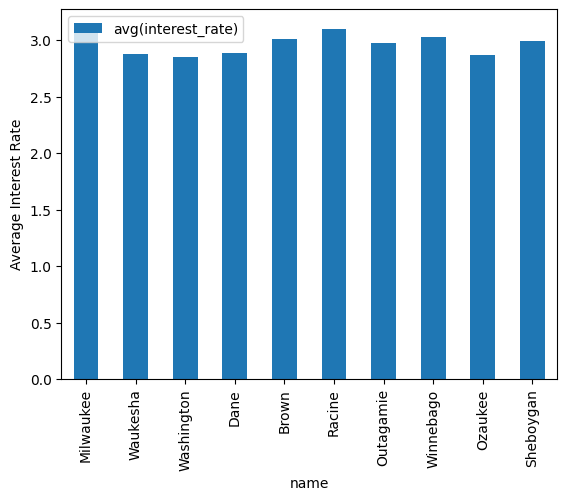

In [17]:
plot_df.set_index("name").plot.bar(ylabel = 'Average Interest Rate')

# Q8

In [36]:
plot_df2 = spark.sql("""
        SELECT name, loan_amount/1000000 as loan_amounts_in_million
        FROM(
            SELECT name, loan_amount,
            DENSE_RANK() OVER (PARTITION BY name ORDER BY loan_amount DESC) AS rank
            FROM counties_code
            INNER JOIN loans ON loans.county_code = counties_code.counties_code
            )
        WHERE rank = 2
        ORDER BY loan_amount DESC
        LIMIT 10
        """).toPandas()
plot_df2

,name,loan_amounts_in_million
0,Kenosha,66.005
1,Dane,52.005
2,Milwaukee,42.005
3,Waukesha,30.005
4,Ozaukee,29.915
5,Walworth,17.695
6,Brown,17.215
7,La Crosse,15.955
8,Washington,11.705
9,Outagamie,10.965


<Axes: xlabel='name', ylabel='2nd Biggest Loan Application (Millions $)'>

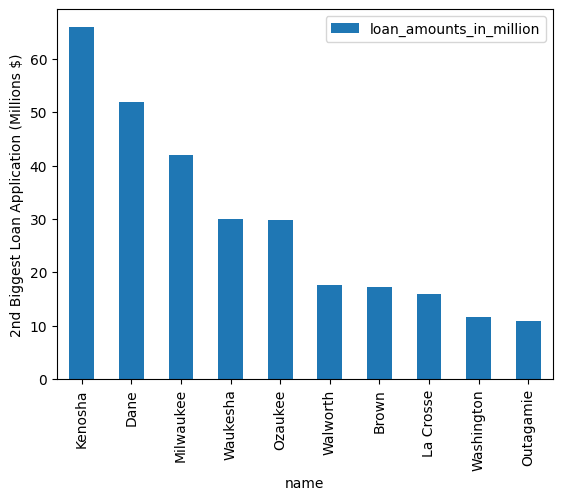

In [37]:
plot_df2.set_index("name").plot.bar(ylabel = '2nd Biggest Loan Application (Millions $)')

# Q9

In [35]:
cache_df = spark.sql(
    """
    SELECT interest_rate
    FROM banks
    INNER JOIN loans
    ON banks.lei_2020 = loans.lei 
    WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
    """)
cache_df.toPandas()

,interest_rate
0,NA
1,NA
2,NA
3,NA
4,2.375
...,...
12482,3.75
12483,3.625
12484,6.0
12485,NA
